<a href="https://colab.research.google.com/github/rastringer/GPU_CUDA_overview/blob/main/python_cuda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python and CUDA

One of the most popular libraries for writing CUDA code in Python is *Numba*, a just-in-time, type-specific, function compiler that runs on either CPU or GPU.

There is also pyCUDA, which requires writing C code within Python and generally requires more modifications than Numba. We will focus on Numba since it is easier to begin with.

In [1]:
from numba import jit, cuda
import math
import numpy as np

@cuda.jit
def multiply_kernel(x, y, out):
    i = cuda.grid(1)
    if i < x.shape[0]:
        # Perform the addition
        result = x[i] * y[i]
        out[i] = result

In [30]:
n = 3200
x = np.arange(n).astype(np.int32)
print(x)

[   0    1    2 ... 3197 3198 3199]


In [39]:
y = np.full_like(x, 10)
print(y)

[10 10 10 ... 10 10 10]


In [40]:
d_x = cuda.to_device(x)
d_y = cuda.to_device(y)
d_out = cuda.device_array_like(d_x)

In [41]:
threads_per_block = 256
# math.ceil rounds up to the nearest integer, ensuring we have enough blocks  to cover all elements.
blocks_per_grid = math.ceil(n / threads_per_block)
print(f"threads per block: {threads_per_block}, blocks per grid: {blocks_per_grid}")

threads per block: 256, blocks per grid: 13


In [44]:
multiply_kernel[blocks_per_grid, threads_per_block](d_x, d_y, d_out)
cuda.synchronize()

# Copy the result back to the host
result = d_out.copy_to_host()

print("First 10 results:", result[:10])
print("Last 10 results:", result[-10:])

First 10 results: [ 0 10 20 30 40 50 60 70 80 90]
Last 10 results: [31900 31910 31920 31930 31940 31950 31960 31970 31980 31990]


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 13 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


## Mandelbrot set

The Mandelbrot set is a two-dimensional, geometric representation of a fractal and can create visually stunning images.

In the following code, we see

```
c_real = min_x + (max_x - min_x) * col / width
c_imag = min_y + (max_y - min_y) * row / height
```

These lines map pixel coordinates to a point in a complex plane.

We iterate using the function `f(z) = z^2 + c`, where z and c are complex numbers.

```
x = 0  # Real part of z
y = 0  # Imaginary part of z
for i in range(max_iters):
    if x*x + y*y > 4.0:
        break
    x_new = x*x - y*y + c_real
    y = 2*x*y + c_imag
    x = x_new
```

By checking if the absolute value of z is greater than 2. If |z| > 2, we know it will escape to infinity.

With, `x_new = x*x - y*y + c_real` we calculate the real part of z^2 + c.
For a complex number z = a + bi, the real part of z^2 is a^2 - b^2.

`y = 2*x*y + c_imag`: This calculates the imaginary part of z^2 + c.

The imaginary part of z^2 is 2ab.

Convergence Test:

The Mandelbrot set is defined as the set of points c in the complex plane for which the function f(z) = z^2 + c does not diverge when iterated from z = 0. In practice, we use a finite number of iterations (max_iters) and check if |z| <=

If the iteration reaches max_iters without |z| exceeding 2, we consider the point to be in the Mandelbrot set. The number of iterations before |z| > 2 determines the color of points outside the set, creating the characteristic fractal patterns.

`output[row, col] = i` stores the number of iterations it took for the point to escape -- this value is used for coloring the plot.


The Mandelbrot set can be useful for learning CUDA concepts since we can parallelize across threads and use memory access patterns, as well as GPU-CPU interaction. The calculations are done on the GPU, then sent back to the CPU for the display plot.

/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:888: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


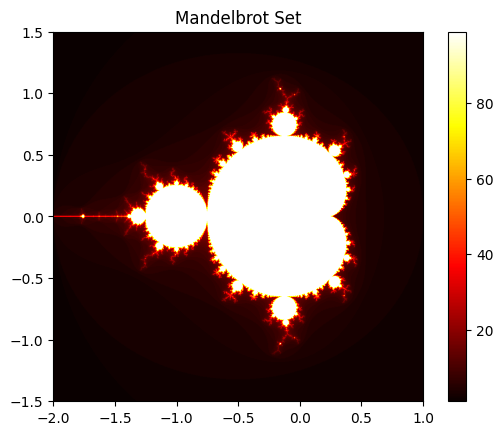

In [1]:
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt

# CUDA kernel function
@cuda.jit
def mandelbrot_kernel(min_x, max_x, min_y, max_y, width, height, max_iters, output):
    # Get the 2D thread position within the grid
    row, col = cuda.grid(2)

    # Check if the thread is within the image bounds
    if row < height and col < width:
        c_real = min_x + (max_x - min_x) * col / width
        c_imag = min_y + (max_y - min_y) * row / height

        # Mandelbrot set iteration
        x = 0
        y = 0
        for i in range(max_iters):
            # Check if the point has escaped
            if x*x + y*y > 4.0:
                break
            # Update x and y
            x_new = x*x - y*y + c_real
            y = 2*x*y + c_imag
            x = x_new

        # Store the number of iterations in the output array
        output[row, col] = i

# Set up and launch kernel
def plot_mandelbrot(min_x, max_x, min_y, max_y, width, height, max_iters):
    # Output array
    output = np.zeros((height, width), dtype=np.uint32)
    # Thread block and grid dimensions
    threads_per_block = (16, 16)
    blocks_per_grid = ((width + threads_per_block[0] - 1) // threads_per_block[0],
                       (height + threads_per_block[1] - 1) // threads_per_block[1])

    # Launch kernel
    mandelbrot_kernel[blocks_per_grid, threads_per_block](
        min_x, max_x, min_y, max_y, width, height, max_iters, output
    )

    # Plot image
    plt.imshow(output, cmap='hot', extent=[min_x, max_x, min_y, max_y])
    plt.colorbar()
    plt.title('Mandelbrot Set')
    plt.show()

# Example usage
plot_mandelbrot(-2, 1, -1.5, 1.5, 1000, 1000, 100)

# Additional puzzle: Modify the code to zoom into an interesting part of the Mandelbrot set
# Hint: Adjust the min_x, max_x, min_y, max_y parameters